In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tvt
from torch.utils.data.sampler import SubsetRandomSampler
import torch_directml
import matplotlib.pyplot as plt
import matplotlib.patches as ph
from pycocotools.coco import COCO
import numpy as np
from PIL import Image
import random
import os, time, gc
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import functools

# use directml to run codes on AMD GPU
dml = torch_directml.device()
dml

device(type='privateuseone', index=0)

In [4]:
annType = []
# annType = annType[1]      #specify type here
catType = ['airplane','bus','cat','dog','pizza']
prefix = 'person_keypoints' if annType=='keypoints' else 'instances'
print('Running demo for *%s* results.'%(annType))
dataDir='./coco'
dataType='train2014'
annFile = '%s/annotations/%s_%s.json'%(dataDir,prefix,dataType)
cocoGt=COCO(annFile)

Running demo for *[]* results.
loading annotations into memory...
Done (t=7.45s)
creating index...
index created!


In [5]:
cats = cocoGt.loadCats(cocoGt.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))
cocoGt.getCatIds(catNms=['pizza'])

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush



[59]

In [6]:
imgId = cocoGt.getImgIds(catIds=[59])[2]
cocoGt.getAnnIds(imgIds=[imgId])
cocoGt.loadImgs(imgId)[0]

{'license': 1,
 'file_name': 'COCO_train2014_000000548874.jpg',
 'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000548874.jpg',
 'height': 480,
 'width': 640,
 'date_captured': '2013-11-19 21:14:26',
 'flickr_url': 'http://farm1.staticflickr.com/139/404544387_58a31e803d_z.jpg',
 'id': 548874}

In [36]:
imginfo = cocoGt.loadImgs(548874)[0]
cocoGt.loadAnns(cocoGt.getAnnIds(imgIds=imgId))[2]['area']

1126.0780500000008

In [35]:
catIds = cocoGt.getCatIds(catNms=['bus', 'cat', 'pizza'])
sets = [set(cocoGt.getImgIds(catIds=catId)) for catId in catIds]
imgIds = functools.reduce(lambda a, b: a.union(b), sets)
len(imgIds)

7799

In [9]:
class DataInfo:
    def __init__(self, dir='/home/parry/gitRepos/homeworks_ECE_60146/hw5_YuxinSun/coco', *, type='train2014', categories=None) -> None:
        self.dir  = dir
        self.type = type
        self.annFile = '%s/annotations/%s_%s.json'%(self.dir,'instances',self.type)
        # target images' information:
        self.ctgs = categories
        self.h = 256
        self.w = 256
        self.maxArea = 40000

def xywh_to_xyxy(cbox):
    return torch.tensor(
        [
            cbox[0], 
            cbox[1],
            cbox[0]+cbox[2], 
            cbox[1]+cbox[3]
        ]
    ).float()

class MyDataset(torch.utils.data.Dataset):
    xform = tvt.Compose([
        tvt.ToTensor(),
        # transform to range [-1, 1]:
        tvt.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ])
    def __init__(self, data: DataInfo, *, save_dir="/home/parry/gitRepos/homeworks_ECE_60146/hw5_YuxinSun/resized", update=False):

        cocoGt   = COCO(data.annFile)
        self.coco= cocoGt
        catType  = data.ctgs
        self.catIds = cocoGt.getCatIds(catNms=catType)
        self.dir = save_dir
        self.data = data
        self.catId_to_label = {cocoGt.getCatIds(catType[i])[0]: i  for i in range(len(catType))}
        self.label_to_cat = {i: catType[i] for i in range(len(catType))}

        self.anns = self.gen_data_id(cocoGt, catType, update)


    # return data and label(it is actually the categoryID)
    def gen_data_id(self, cocoGt, catType, update=False):
        catIds = cocoGt.getCatIds(catNms=catType)
        sets = [set(cocoGt.getImgIds(catIds=[catId])) for catId in catIds]
        imgIds = functools.reduce(lambda a, b: a.union(b), sets)
        anns = []
        for imgId in imgIds:
            current_anns = cocoGt.loadAnns(cocoGt.getAnnIds(imgIds=imgId, iscrowd=False))
            max_area = self.data.maxArea
            annId = None
            
            # find dominant object
            for ann in current_anns:
                if ann['category_id'] in self.catIds \
                and ann['area'] > max_area:
                    max_area = ann['area']
                    annId = ann['id']

            if annId is not None:
                anns.append(annId)
                self.gen_resized_image(imgId, update)
            # switch to next image
        return anns

    def resize(self, im, bbox):
        w_ori = im['width']
        h_ori = im['height']
        # xi, yi are in range [0,1]
        new_box = [bbox[0]/w_ori, bbox[1]/h_ori, \
                   bbox[2]/w_ori, bbox[3]/h_ori]
        return new_box

    def gen_resized_image(self, imgId, update):
        im = self.coco.loadImgs(imgId)[0]
        orig_path = '%s/%s/%s'%(self.data.dir, self.data.type, im['file_name'])
        save_path = '%s/%s'%(self.dir, im['file_name'])
        if update or not os.path.exists(save_path):
            img = Image.open(orig_path)
            if img.mode != 'RGB':
            # force update if it is not RGB
                img = img.convert('RGB')
            img = img.resize((self.data.w, self.data.h), resample=Image.Resampling.LANCZOS)
            img.save(save_path)

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, index):
        ann = self.coco.loadAnns(self.anns[index])[0]
        im  = self.coco.loadImgs(ann['image_id'])[0]
        path = '%s/%s'%(self.dir, im['file_name'])
        pil_image = Image.open(path)
        img_tensor = self.xform(pil_image)
        bbox = ann['bbox']
        label = self.catId_to_label[ann['category_id']] 
        new_bbox = torch.tensor(self.resize(im, bbox)).float()
        return img_tensor, label, new_bbox, ann['image_id']

datainfo = DataInfo(type='train2014', categories=['bus', 'cat', 'pizza'])
dataset  = MyDataset(datainfo, update=False)

print("done!")

loading annotations into memory...
Done (t=6.13s)
creating index...
index created!
done!


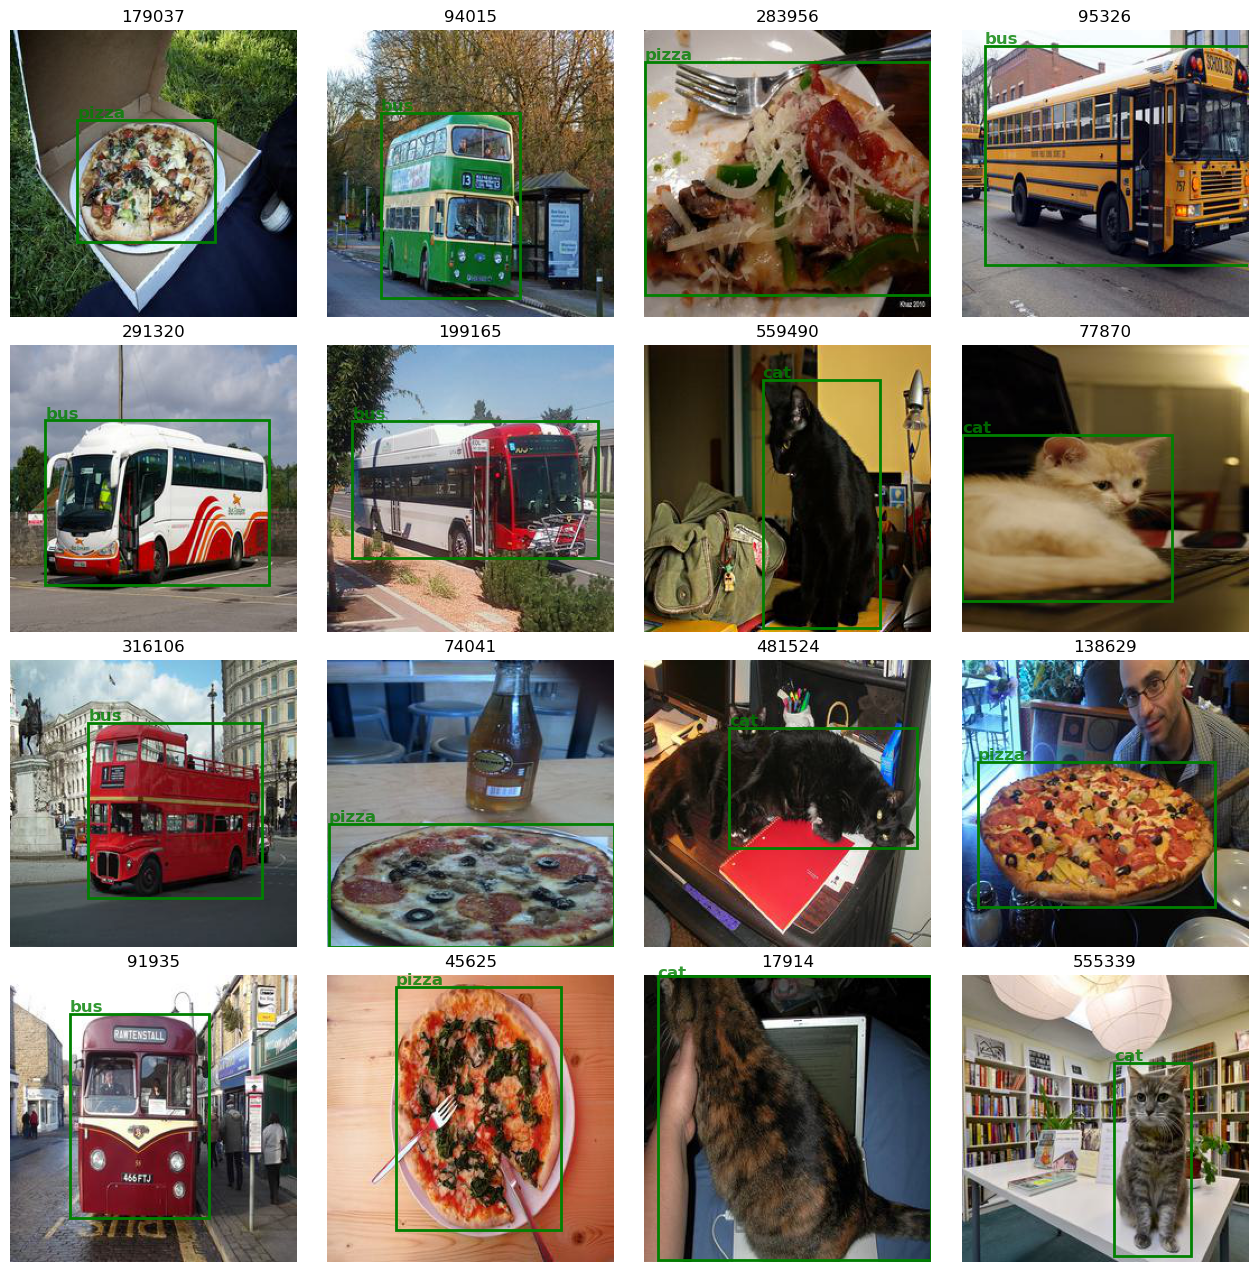

In [12]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

xform2 = tvt.Compose([
    # transform to range [-1, 1]:
    tvt.Normalize([-1,-1,-1], [2,2,2]),
    tvt.ToPILImage()
])

fig, axs = plt.subplots(nrows=4, ncols=4, squeeze=False, figsize=[16,16])
plt.subplots_adjust(wspace=0.1, hspace=0.1)
axs = axs.flatten()

for iter, data in enumerate(dataloader):
    if iter >= 16: break
    img_tensor, labs_tensor, bbox_tensor, img_id = data

    img = img_tensor[0]
    ground_bbox = bbox_tensor[0]

    ax = axs[iter]
    ax.imshow(xform2(img))
    ax.title.set_text(str(img_id[0].item()))

    b = (ground_bbox*256).tolist()
    cate = dataset.label_to_cat[labs_tensor[0].item()]
    ax.axis('off')
    ax.add_patch(plt.Rectangle((b[0], b[1]), b[2], b[3],fill=False, lw=2, edgecolor='g'))
    ax.annotate(cate, (b[0], b[1]-2 if b[1]-2 >= 1.0 else 1.0), color='g', weight='bold', fontsize=12,alpha=0.8)
# ax1.add_patch(plt.Rectangle((b[0], b[1]), b[2], b[3],fill=False, lw=2, edgecolor='r'))
# ax1.annotate("car", (b[0], b[1]-2), color='r', weight='bold', fontsize=12,alpha=0.8)
# bbox = torch.tensor([0.3, 0.3, 0.6, 0.6], dtype=torch.float)

plt.show()

In [ ]:
class SkipBlock(nn.Module):
    def __init__(self, in_ch, out_ch, ker=3, *, stride=1, padding=1) -> None:
        super().__init__()
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.stride = stride
        self.conv1 = nn.Conv2d(in_ch, out_ch, ker, stride=stride, padding=padding, bias=False)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)
        if stride != 1 or in_ch != out_ch:
            # would have bugs if ker!=3
            if stride != 2:
                raise ValueError('Currently stride must be 1 or 2.')
            self.downsampler = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 1, stride=stride, padding=0, bias=False),
                nn.BatchNorm2d(out_ch),
            )
        else:
            self.downsampler = None

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsampler is not None:
            identity = self.downsampler(x)
        out = out + identity
        out = self.relu(out)

        return out
    
class HW5Net1(nn.Module):

    def __init__(self, in_ch=3, out_ch=3, ngf=32):
        super(HW5Net1, self).__init__()

        # The first convolution layer. Input shape: (B, 3, 256, 256)
        model = nn.ModuleList([
            nn.Conv2d(in_ch, ngf, 6, padding=2, stride=2, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(inplace=True),
        ])
        # out_size: 128

        # The second convolution layer, downsample only once before skip-block
        model.extend([
            nn.Conv2d(ngf, ngf * 2, 6, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True),
        ])
        # out_size: 64

        self.model = nn.Sequential(*model)

        ###
        # classification skip-blocks
        ###
        new_in_ch = ngf * 2
        num_blocks = [4, 4, 3]
        new_out_chs = [64, 128, 256]
        cls_head = nn.ModuleList()
        for i in range(len(num_blocks)):
            new_out_ch = new_out_chs[i]
            num_block  = num_blocks[i]
            cls_head.extend(
                self._gen_skip_blocks(new_in_ch, new_out_ch, num_block, stride=2, padding=1)
            )
            new_in_ch = new_out_ch
        # out_size: 8

        # cls_head.append(nn.MaxPool2d(3, stride=2, padding=1))
        cls_head.append(nn.AvgPool2d(2, stride=2, padding=0))
        # out_size: 256x4x4

        # The classification fc-layers
        cls_head.extend([
            nn.Flatten(),
            nn.Linear(new_out_ch*4*4, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 4),
        ])
        self.cls_head = nn.Sequential(*cls_head)

        ###
        # The regression head
        ###
        reg_head = nn.ModuleList()
        reg_head.append(
            nn.MaxPool2d(3, stride=2, padding=1)
        )
        new_in_ch = ngf * 2
        num_blocks = [4, 4, 3]
        new_out_chs = [64, 128, 256]
        for i in range(len(num_blocks)):
            new_out_ch = new_out_chs[i]
            num_block  = num_blocks[i]
            reg_head.extend(
                self._gen_skip_blocks(new_in_ch, new_out_ch, num_block, stride=2, padding=1)
            )
            new_in_ch = new_out_ch
        # The regression fc-layers
        reg_head.extend([
            nn.Flatten(),
            nn.Linear(new_out_ch*4*4, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 4),
            nn.Sigmoid()
        ])
        self.reg_head = nn.Sequential(*reg_head)

    @staticmethod
    def _gen_skip_blocks(in_ch, out_ch, num_layer, *, stride=1, padding=1):
        # the first skip-block will downsample the input if necessary.
        layers = [SkipBlock(in_ch, out_ch, stride=stride, padding=padding),]
        for _ in range(1, num_layer):
            # the following skip-blocks will keep the input size unchanged.
            layers.append(SkipBlock(out_ch, out_ch, stride=1, padding=1))
        return layers

    def forward(self, x):
        out = self.model(x)
        cls_out = self.cls_head(out)
        bbox_out = self.reg_head(out)
        return cls_out, bbox_out
    

class HW5Net2(nn.Module):

    def __init__(self, in_ch=3, out_ch=3, ngf=32):
        super(HW5Net2, self).__init__()

        # The first convolution layer. Input shape: (B, 3, 256, 256)
        model = nn.ModuleList([
            nn.Conv2d(in_ch, ngf, 6, padding=2, stride=2, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(inplace=True),
        ])
        # out_size: 128

        # The second convolution layer, downsample only once before skip-block
        model.extend([
            nn.Conv2d(ngf, ngf * 2, 6, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True),
        ])
        # out_size: 64

        new_in_ch = ngf * 2
        num_blocks = [6, 6, 3]
        new_out_chs = [64, 128, 256]
        for i in range(len(num_blocks)):
            new_out_ch = new_out_chs[i]
            num_block  = num_blocks[i]
            model.extend(
                self._gen_skip_blocks(new_in_ch, new_out_ch, num_block, stride=2, padding=1)
            )
            new_in_ch = new_out_ch
        self.model = nn.Sequential(*model)
        # out_size: 8

        ###
        # classification skip-blocks
        ###
        cls_head = nn.ModuleList([
            nn.Conv2d(256, 256, 4, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        ])
        # out_size: 256x3x3

        # The classification fc-layers
        cls_head.extend([
            nn.Flatten(),
            nn.Linear(new_out_ch*3*3, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 4),
        ])
        self.cls_head = nn.Sequential(*cls_head)

        ###
        # The regression head
        ###
        reg_head = nn.ModuleList([
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 4, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        ])
        # out_size: 256x3x3

        reg_head.extend([
            nn.Flatten(),
            nn.Linear(new_out_ch*3*3, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, 4),
            nn.Sigmoid()
        ])
        self.reg_head = nn.Sequential(*reg_head)

    @staticmethod
    def _gen_skip_blocks(in_ch, out_ch, num_layer, *, stride=1, padding=1):
        # the first skip-block will downsample the input if necessary.
        layers = [SkipBlock(in_ch, out_ch, stride=stride, padding=padding),]
        for _ in range(1, num_layer):
            # the following skip-blocks will keep the input size unchanged.
            layers.append(SkipBlock(out_ch, out_ch, stride=1, padding=1))
        return layers

    def forward(self, x):
        out = self.model(x)
        cls_out = self.cls_head(out)
        bbox_out = self.reg_head(out)
        return cls_out, bbox_out
        




In [1]:
def calc(x, ker=3, *, stride=1, padding=1):
    return ((x+2*padding-ker) / stride + 1.0)//1


# calc(256, 5, stride=3, padding=1)
calc(256, 5, stride=3, padding=2)
# calc(11, 3, stride=2, padding=0)

86.0

In [3]:
calc(8, 4, padding=1, stride=2)

4.0